In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../src/')

%load_ext autoreload
%autoreload 2

import copy
%matplotlib inline
import matplotlib.pyplot as plt
%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import argparse

model_dir = "./models/"
import model_archs
from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy, sws_replace, compressed_model
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets, get_layer_data
from retrain_layer import retrain_layer
retraining_epochs = 50


test_data_full = Variable(test_data(fetch = "data")).cuda()
test_labels_full = Variable(test_data(fetch = "labels")).cuda()
val_data_full = Variable(search_validation_data(fetch = "data")).cuda()
val_labels_full = Variable(search_validation_data(fetch = "labels")).cuda()


/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
#1. Train all 3 layers
#2. Unify model and replace priors
#3. Optimize as usual
def layer_retrain_LeNet_300_100(mean, zmean, temp, tau, mixtures, data_size, loss_type = 'MSEHNA', savedir = ''):
    zvar = 10
    var = 2
    model_name = 'LeNet_300_100'
    
    #train 3 layers independently
    layer_model_1, gmp_1, res_1 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 1, data_size, model_name, loss_type, savedir)
    layer_model_2, gmp_2, res_2 = retrain_layer(mean, var, zmean, zvar, mixtures, 1, tau, 2, data_size, model_name, loss_type, savedir)
    layer_model_3, gmp_3, res_3 = retrain_layer(mean, var, zmean, zvar, mixtures, temp, tau, 3, data_size, model_name, loss_type, savedir)

    #transfer GMP to new unified model architecture
    unified_model = sws_replace(model_archs.LeNet_300_100().cuda(), [layer_model_1.state_dict(), layer_model_2.state_dict(), layer_model_3.state_dict()])
    gmp_u1 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc1.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_1.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u2 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc2.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_2.means.clone().data.cpu().numpy(), scaling = False)
    gmp_u3 = GaussianMixturePrior(mixtures, [x for x in unified_model.fc3.parameters()], 0.99, zero_ab = get_ab(zmean, zvar), ab = get_ab(mean, var), means = gmp_3.means.clone().data.cpu().numpy(), scaling = False)

    #load datasets
    data_size = 'search'
    if(data_size == 'search'):
        train_dataset = search_train_data()
        val_data_full = Variable(test_data(fetch='data')).cuda()
        val_labels_full = Variable(test_data(fetch='labels')).cuda()
        un_val_acc = test_accuracy(val_data_full, val_labels_full, unified_model)[0]
    if(data_size == 'full'):
        train_dataset = train_data()

    loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    
    
    #unified accuracy
    unify_res = plot_data(unified_model, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures)
    unify_res.data_epoch(0, unified_model)
    
    #init optimizers
    loss_type = 'CESNT'
    opt_1 = torch.optim.Adam([
            {'params': unified_model.fc1.parameters(), 'lr': 1e-4},
            {'params': [gmp_u1.means], 'lr': 3e-4},
            {'params': [gmp_u1.gammas, gmp_u1.rhos], 'lr': 3e-3}])
    opt_2 = torch.optim.Adam([
            {'params': unified_model.fc2.parameters(), 'lr': 1e-4},
            {'params': [gmp_u2.means], 'lr': 3e-4},
            {'params': [gmp_u2.gammas, gmp_u2.rhos], 'lr': 3e-3}])
    opt_3 = torch.optim.Adam([
            {'params': unified_model.fc3.parameters(), 'lr': 1e-4},
            {'params': [gmp_u3.means], 'lr': 3e-4},
            {'params': [gmp_u3.gammas, gmp_u3.rhos], 'lr': 3e-3}])

    #align and retrain
    show_sws_weights(unified_model)
    retraining_epochs=30
    for epoch in range(retraining_epochs):
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u1, opt_1, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u2, opt_2, loader, tau, 1, loss_type)
        unified_model, loss = retrain_sws_epoch(unified_model, gmp_u3, opt_3, loader, tau, 1, loss_type)
        #test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
        #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))
        #model_n, means = clamp_weights (model_n, means)
        unify_res.data_epoch(epoch+1, unified_model)
        
        if (trueAfterN(epoch, 10)):
            print ("Epoch: {}, Test Acc: {:.2f}".format(epoch+1, unify_res.test_accuracy[-1]))
    show_sws_weights(unified_model)

    #prune model
    l1_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc1.bias", "fc1.weight")), gmp_u1)
    l2_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc2.bias", "fc2.weight")), gmp_u2)
    l3_prune = sws_prune(dict((l, unified_model.state_dict()[l]) for l in ("fc3.bias", "fc3.weight")), gmp_u3)
    pruned_model = sws_replace(unified_model, [l1_prune, l2_prune, l3_prune])
    
    unify_res.data_prune(pruned_model)
    
    ures = unify_res.gen_dict()
    cm = compressed_model(pruned_model.state_dict(), [gmp_u1, gmp_u2, gmp_u3])
    ures['cm'] = cm.get_cr_list()

    show_sws_weights(pruned_model)
        
    ###SAVE MODEL, GMP, Res
    if (savedir != ""):
        exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}".format(unified_model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), data_size)
        torch.save(unified_model, savedir + '/mnist_retrain_layer_umodel_{}.m'.format(exp_name))
        with open(savedir + '/mnist_retrain_layer_u1gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u1, f)
        with open(savedir + '/mnist_retrain_layer_u2gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u2, f)
        with open(savedir + '/mnist_retrain_layer_u3gmp_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(gmp_u3, f)
        with open(savedir + '/mnist_retrain_layer_ures_{}.p'.format(exp_name),'wb') as f:
            pickle.dump(ures, f)
    
    return layer_model_1, gmp_1, res_1, layer_model_2, gmp_2, res_2, layer_model_3, gmp_3, res_3, unified_model, ures

In [5]:
! ls ./expfiles

mnist_retrain_layer_gmp_LeNet_300_100FC1_m5000_zm5000_r10_t0.0001_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC1_m5000_zm5000_r10_t1e-05_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC1_m5000_zm5000_r10_t1e-06_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC1_m5000_zm5000_r10_t1e-07_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC2_m5000_zm5000_r10_t0.0001_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC2_m5000_zm5000_r10_t1e-05_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC2_m5000_zm5000_r10_t1e-06_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC2_m5000_zm5000_r10_t1e-07_m15_kdT1_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC3_m5000_zm5000_r10_t0.0001_m15_kdT4_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC3_m5000_zm5000_r10_t1e-05_m15_kdT4_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC3_m5000_zm5000_r10_t1e-06_m15_kdT4_search.p
mnist_retrain_layer_gmp_LeNet_300_100FC3_m5000_zm5000_r10_t1e-07_m15_kdT4_search.p
m

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 97.31% - Prune: 92.90% - Quantize: 94.91% - Sparsity: 70.05%
Original: 98.15% - Retrain: 97.34% - Prune: 93.69% - Quantize: 95.33% - Sparsity: 70.05%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.07% - Prune: 98.05% - Quantize: 98.00% - Sparsity: 46.10%
Original: 98.15% - Retrain: 98.01% - Prune: 98.02% - Quantize: 97.97% - Sparsity: 46.10%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.26% - Prune: 98.23% - Quantize: 98.17% - Sparsity: 20.20%
Original: 98.15% - Retrain: 98.17% - Prune: 98.19% - Quantize: 98.02% - Sparsity: 20.20%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 1

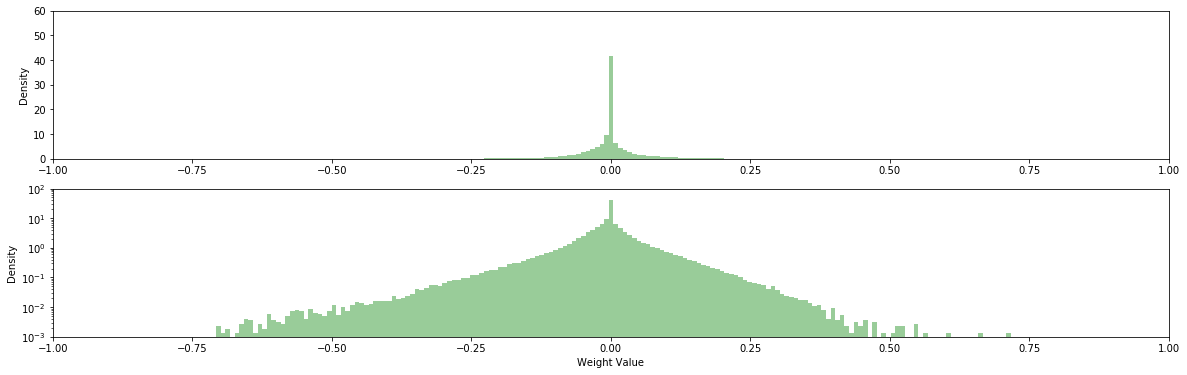

Layer Loss: 116345.102
Layer Loss: 144.393
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 16445.088
Layer Loss: 49.119
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 845.117
Layer Loss: 4.947
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 46.13
Epoch: 20, Test Acc: 50.39
Epoch: 30, Test Acc: 64.59


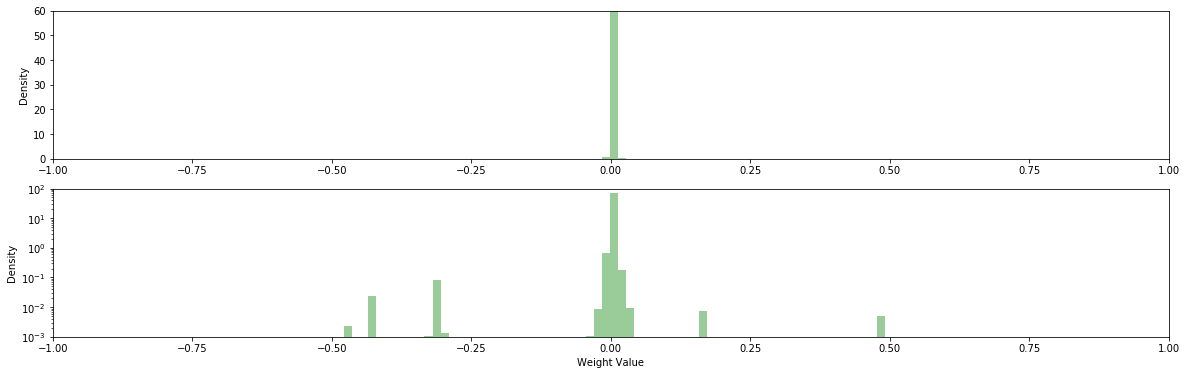

[ 0.         -0.5974142  -0.47642952 -0.31225044 -0.62465727 -0.36103201
 -0.00208579 -0.001132   -0.00110096 -0.00107573  0.40481514  0.47957021
  0.38521922  0.27273279  0.15988311]
[0 0 0 ... 0 0 0]
[ 0.00000000e+00 -4.30136561e-01 -5.68902433e-01 -1.07780707e+00
 -9.57034528e-01 -5.68962157e-01  5.51961223e-03  1.24526606e-03
  6.15371717e-03  5.53803891e-03  7.67726004e-01  1.51292193e+00
  7.99389005e-01  6.14523590e-01  1.14974141e+00]
[0 0 0 ... 0 0 0]
[ 0.         -0.74698937 -0.76400375 -1.00552058 -0.8145752  -1.3611604
 -0.77663261 -0.37555441 -0.02776178  1.01606464  0.88808233  0.90348572
  0.90139914  0.90351266  1.53002644]
[0 3 0 ... 0 0 0]


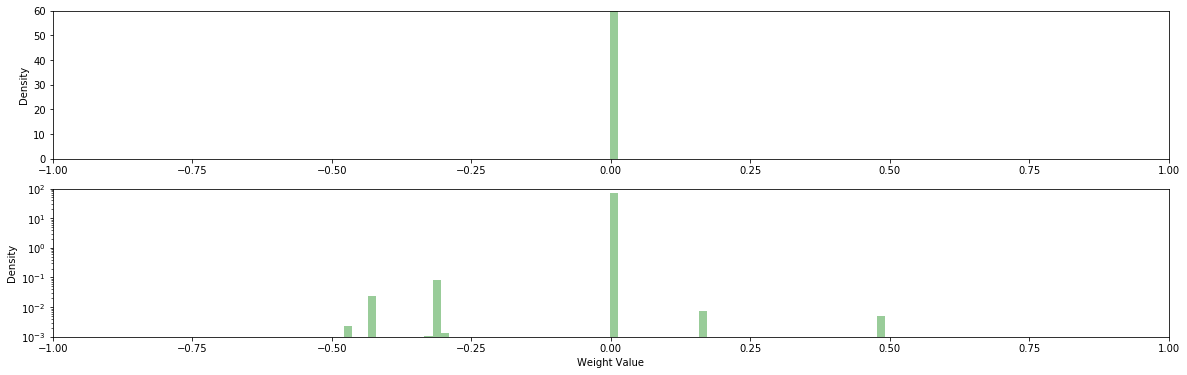

In [4]:
l1_4, g1_4, r1_4, l2_4, g2_4, r2_4, l3_4, g3_4, r3_4, um_4, ur_4 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-4, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.15% - Prune: 97.65% - Quantize: 97.87% - Sparsity: 60.23%
Original: 98.15% - Retrain: 98.11% - Prune: 97.70% - Quantize: 97.94% - Sparsity: 60.23%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.26% - Prune: 98.15% - Quantize: 98.18% - Sparsity: 43.44%
Original: 98.15% - Retrain: 98.18% - Prune: 98.19% - Quantize: 98.14% - Sparsity: 43.44%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.26% - Prune: 98.23% - Quantize: 98.06% - Sparsity: 16.53%
Original: 98.15% - Retrain: 98.15% - Prune: 98.25% - Quantize: 98.12% - Sparsity: 16.53%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 1

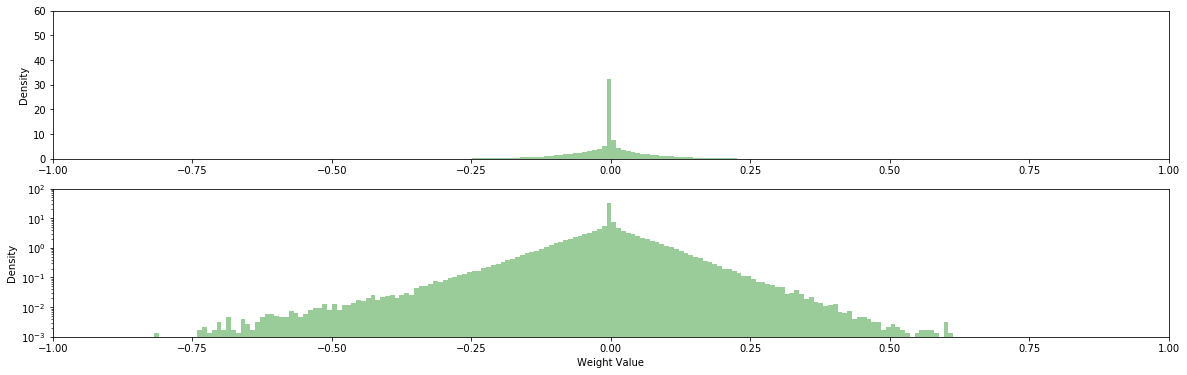

Layer Loss: 119479.102
Layer Loss: 147.621
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 17697.930
Layer Loss: 52.288
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.146
Layer Loss: 5.230
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 94.60
Epoch: 20, Test Acc: 95.10
Epoch: 30, Test Acc: 95.38


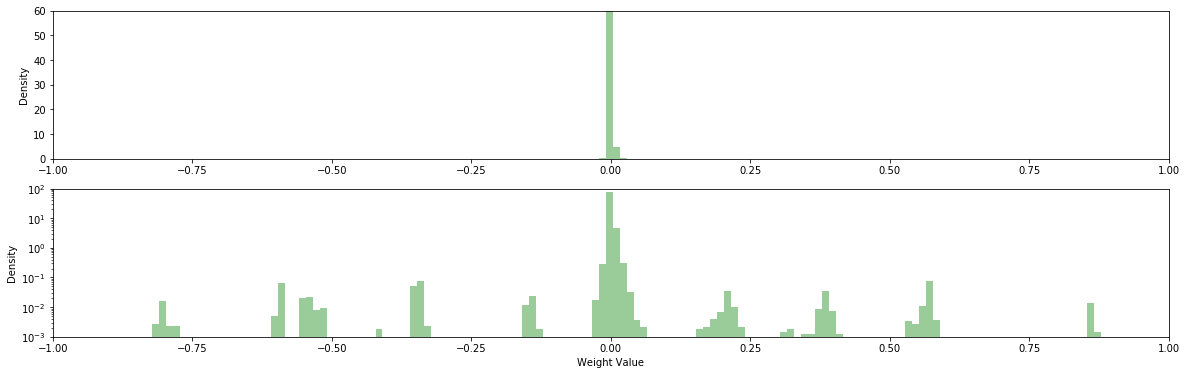

[ 0.00000000e+00 -5.94199836e-01 -5.20802557e-01 -3.46450329e-01
 -5.87966740e-01 -1.44602045e-01 -2.92708329e-03 -3.52660252e-04
 -6.83494844e-04 -2.90591526e-03  5.34767985e-01  2.28110060e-01
  2.28434011e-01  2.28227779e-01  2.11861014e-01]
[ 0  0  0 ...  0 10  0]
[ 0.         -0.59208643 -0.68542951 -0.70602173 -0.77433491 -0.68442154
 -0.02678961  0.32542545  0.03133801  0.17266761  0.61056459  0.63883907
  0.62169719  0.86185825  0.56906551]
[0 0 0 ... 0 9 0]
[ 0.         -0.82635409 -0.80389816 -1.12723577 -0.87085366 -0.54550487
 -0.52632773 -0.40950206  0.08538125  0.38377821  1.04404891  1.11134958
  1.36468804  1.10541689  1.05532324]
[9 2 0 ... 0 0 0]


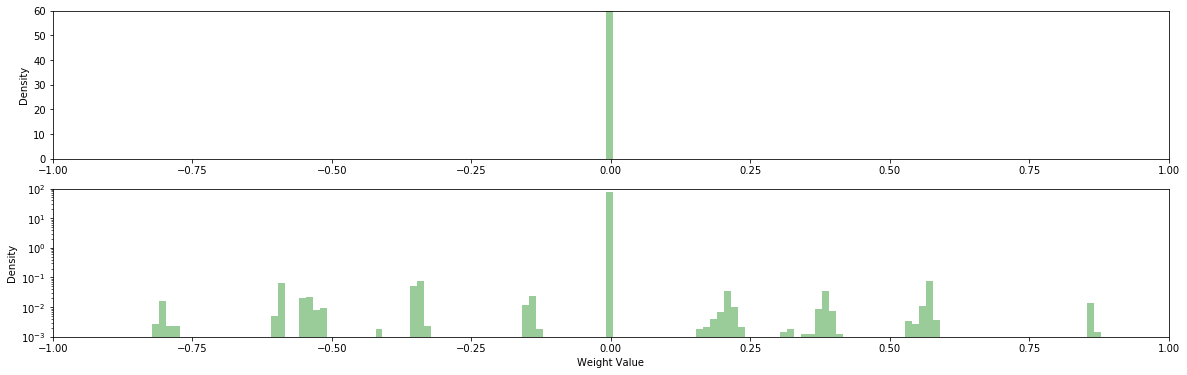

In [6]:
l1_5, g1_5, r1_5, l2_5, g2_5, r2_5, l3_5, g3_5, r3_5, um_5, ur_5 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-5, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.33% - Prune: 97.91% - Quantize: 98.03% - Sparsity: 54.54%
Original: 98.15% - Retrain: 98.23% - Prune: 97.85% - Quantize: 97.94% - Sparsity: 54.54%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.27% - Prune: 98.26% - Quantize: 98.06% - Sparsity: 27.08%
Original: 98.15% - Retrain: 98.15% - Prune: 98.13% - Quantize: 98.12% - Sparsity: 27.08%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.26% - Prune: 98.23% - Quantize: 98.06% - Sparsity: 14.65%
Original: 98.15% - Retrain: 98.15% - Prune: 98.22% - Quantize: 97.95% - Sparsity: 14.65%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 1

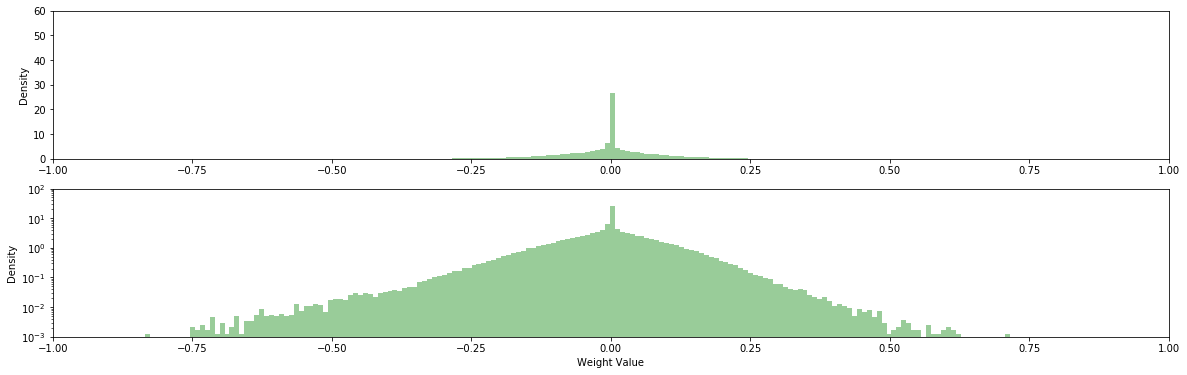

Layer Loss: 124647.180
Layer Loss: 152.975
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 18341.916
Layer Loss: 55.310
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.682
Layer Loss: 5.346
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 97.83
Epoch: 20, Test Acc: 97.78
Epoch: 30, Test Acc: 97.73


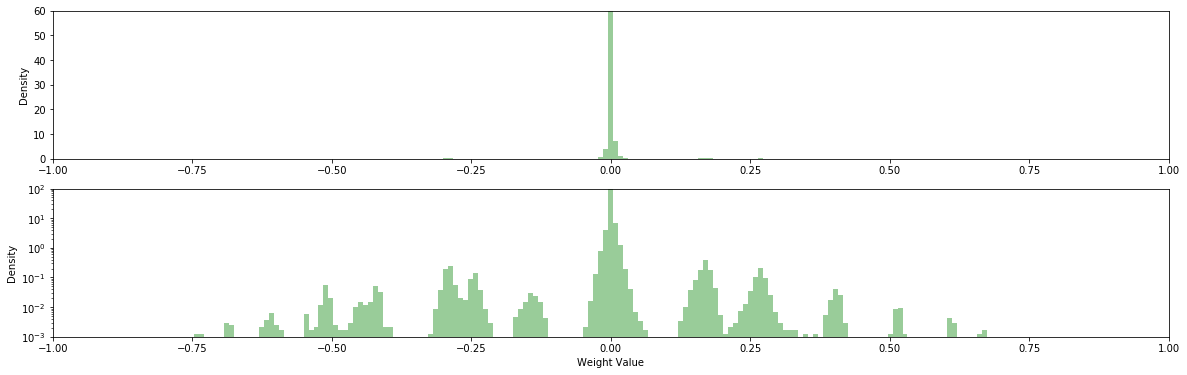

[ 0.         -0.2899887  -0.56303024 -0.5078975  -0.68539202 -0.47270513
 -0.13734916 -0.00707467 -0.00804625  0.02096255  0.60497808  0.25553203
  0.34328246  0.16795892  0.98134786]
[ 0  0  0 ...  0 12  0]
[ 0.         -0.54438996 -0.41827363 -0.53210026 -0.24389385 -0.73588657
 -0.16505392 -0.00715024  0.14906162  0.30582526  0.51319093  0.26620716
  0.66693127  0.40178582  0.61176127]
[ 0  0  0 ... 11  0  0]
[ 0.         -0.7884112  -0.28923729 -0.90703779 -0.61091036 -0.44705591
 -0.63582128 -0.15738218  0.15411861  0.27882573  0.77789986  0.78243512
  0.78341693  0.87521535  0.77024263]
[9 5 2 ... 0 8 0]


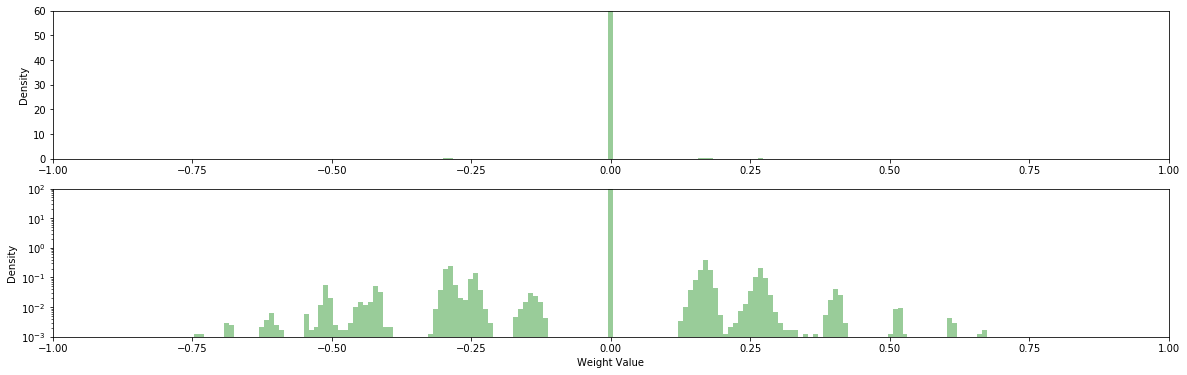

In [7]:
l1_6, g1_6, r1_6, l2_6, g2_6, r2_6, l3_6, g3_6, r3_6, um_6, ur_6 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-6, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.27% - Prune: 98.23% - Quantize: 98.11% - Sparsity: 37.68%
Original: 98.15% - Retrain: 98.15% - Prune: 98.20% - Quantize: 98.06% - Sparsity: 37.68%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.27% - Prune: 98.22% - Quantize: 98.14% - Sparsity: 30.12%
Original: 98.15% - Retrain: 98.15% - Prune: 98.18% - Quantize: 98.18% - Sparsity: 30.12%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
Original: 98.26% - Retrain: 98.26% - Prune: 98.24% - Quantize: 98.17% - Sparsity: 13.86%
Original: 98.15% - Retrain: 98.15% - Prune: 98.23% - Quantize: 98.14% - Sparsity: 13.86%
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 10.0
Non-zero component Mean: 5000.0 Variance: 2.0
0-component Mean: 5000.0 Variance: 1

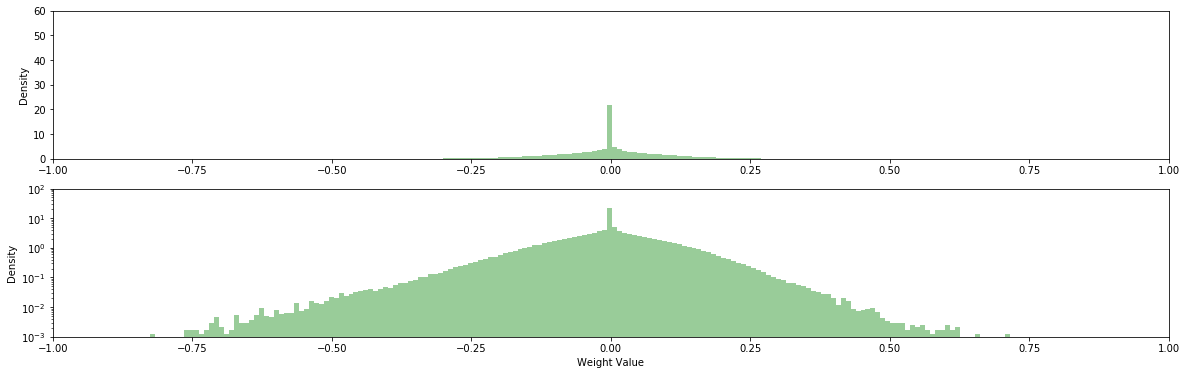

Layer Loss: 129521.578
Layer Loss: 155.089
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 18555.100
Layer Loss: 56.575
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Layer Loss: 849.747
Layer Loss: 5.364
0-neglogprop Loss: -6923469.000
Remaining-neglogprop Loss: -484642912.000
Epoch: 10, Test Acc: 98.16
Epoch: 20, Test Acc: 98.23
Epoch: 30, Test Acc: 98.26


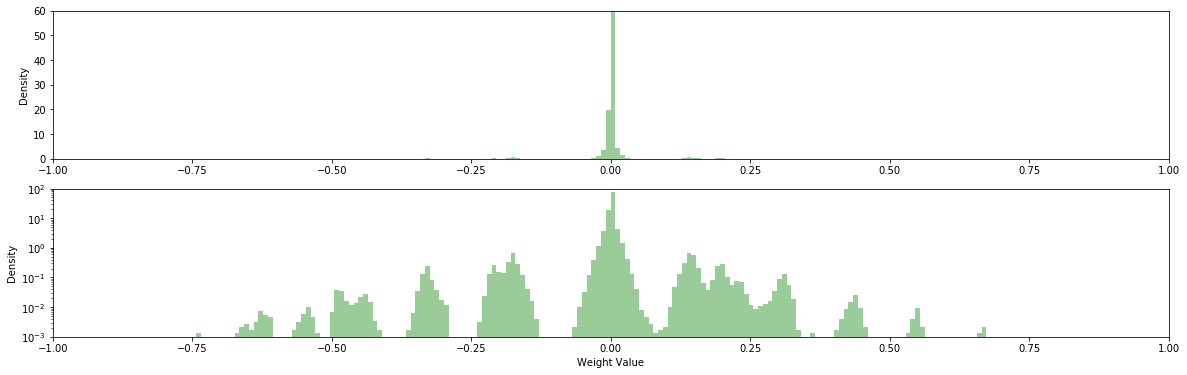

[ 0.         -0.17448039 -0.62103039 -0.80232328 -0.32890353 -0.48473853
 -0.09693296 -0.02097296  0.00170778  0.19535197  0.14192654  0.3115229
  0.22690059  0.41281867  0.99260533]
[ 0  0  0 ...  0 13  0]
[ 0.         -0.43957779 -0.32873863 -0.54237926 -0.20864414 -0.7390824
 -0.26391321 -0.09231971  0.11146436  0.31899282  0.54606235  0.19457234
  0.66759211  0.30780512  0.43477911]
[ 0 11 11 ... 11 11  0]
[ 0.         -0.82620311 -0.19229986 -0.65829474 -0.45893282 -0.32760626
 -0.548208   -0.09147681  0.154872    0.28191239  0.78319299  0.84673166
  0.81937182  0.86054504  0.78021783]
[9 6 5 ... 0 8 0]


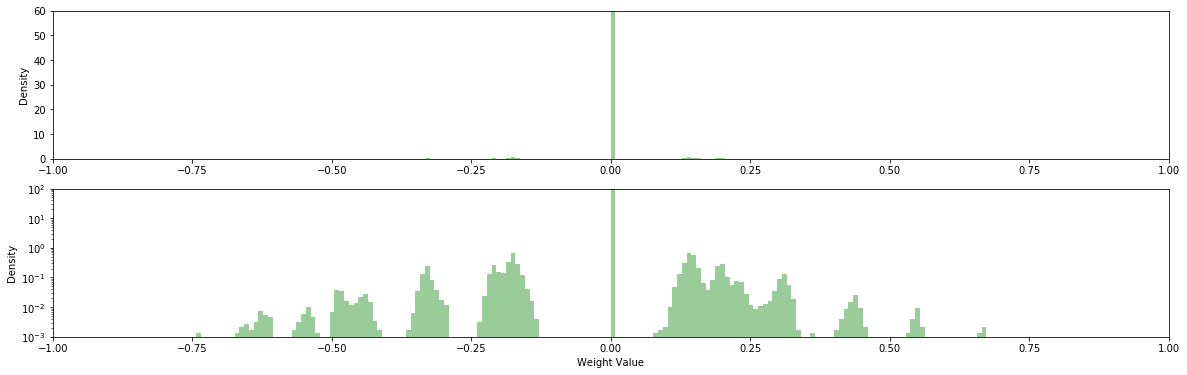

In [8]:
l1_7, g1_7, r1_7, l2_7, g2_7, r2_7, l3_7, g3_7, r3_7, um_7, ur_7 = layer_retrain_LeNet_300_100(mean = 5000, zmean = 5000, temp = 4, tau = 1e-7, mixtures = 15, data_size = 'search', loss_type = 'MSEHNA', savedir = './expfiles/')

In [ ]:
savedir = './expfiles/'

In [ ]:

model_n = copy.deepcopy(prune_model)
data_size = 'search'
if(data_size == 'search'):
    train_dataset = search_train_data()
if(data_size == 'full'):
    train_dataset = train_data()

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
gmp_list = [gmp_1, gmp_2, gmp_3]
means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

for epoch in range(20):
    model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
    #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

    model_n, means = clamp_weights (model_n, means)
    if (trueAfterN(epoch, 10)):
        test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
        print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
        #show_sws_weights(model_n)
    #print (get_sparsity(model_n))
clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
clamped_sp = get_sparsity(model_n)
res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
overall_res += res_str

0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


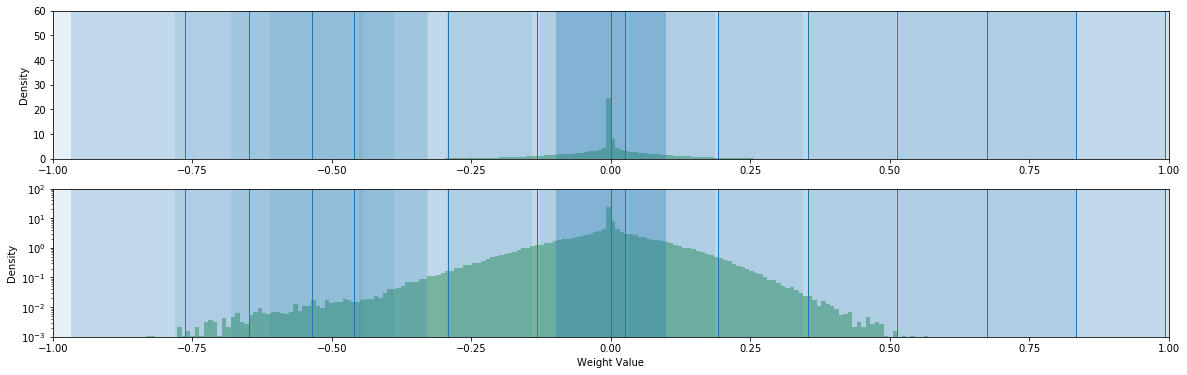

Original: 98.26% - Retrain: 98.28% - Prune: 98.03% - Quantize: 98.07% - Sparsity: 50.79%
Epoch: 50. Loss: 0.00


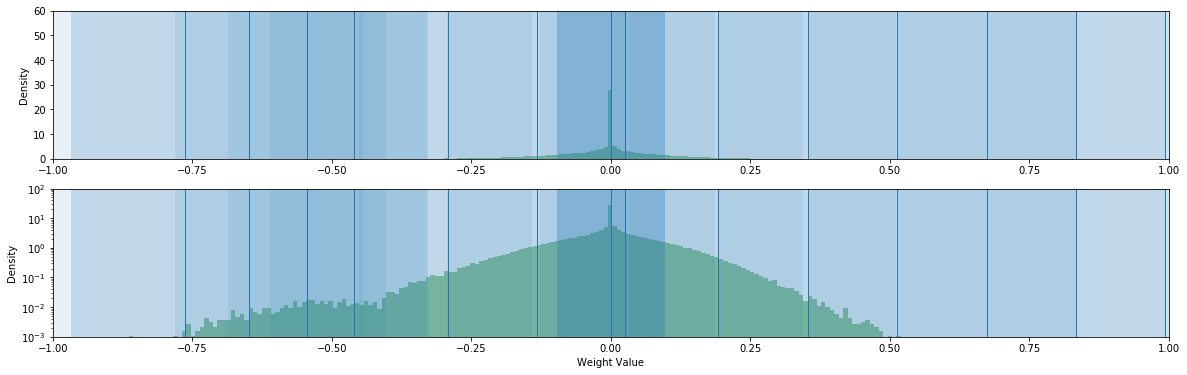

Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
Original: 98.15% - Retrain: 98.12% - Prune: 97.99% - Quantize: 98.03% - Sparsity: 51.51%
Original: 98.26% - Retrain: 98.29% - Prune: 98.04% - Quantize: 98.05% - Sparsity: 51.51%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0
Epoch: 25. Loss: 0.00


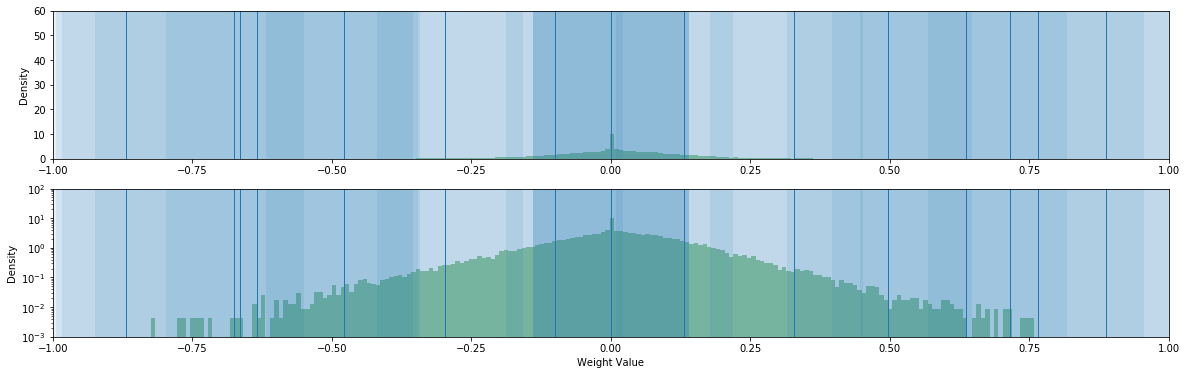

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.09%
Epoch: 50. Loss: 0.00


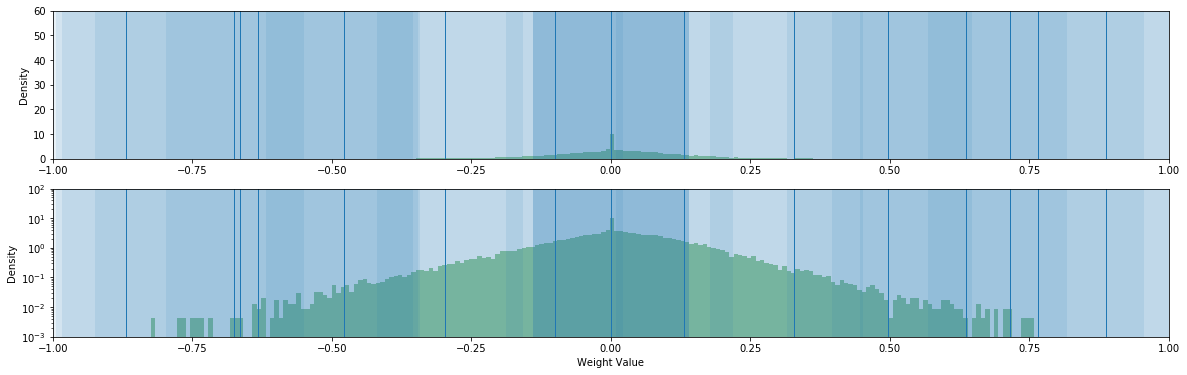

Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
Original: 98.15% - Retrain: 98.15% - Prune: 98.16% - Quantize: 98.08% - Sparsity: 42.16%
Original: 98.26% - Retrain: 98.26% - Prune: 98.27% - Quantize: 98.22% - Sparsity: 42.16%
0-component Mean: 10.0 Variance: 10.0
Non-zero component Mean: 10.0 Variance: 2.0


In [ ]:
overall_res = ""
for mean in [10, 100, 1000, 10000]:
    for zmean in [10, 100, 1000, 10000]:
        res_str = "Mean: {:.2f} ZMean: {:.2f}\n".format(mean,zmean)
        layer_model_1, gmp_1, res_1 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 1, 'MSEHNA')
        layer_model_2, gmp_2, res_2 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-7, 2, 'MSEHNA')
        layer_model_3, gmp_3, res_3 = layer_exp(mean, 2, zmean, 10, 15, 1, 1e-8, 3, 'MSEHNA')
        prune_model = sws_replace(model_archs.LeNet_300_100().cuda(), [sws_prune_l2(layer_model_1, gmp_1), sws_prune_l2(layer_model_2, gmp_2), sws_prune_l2(layer_model_3, gmp_3)])
        test_acc = test_accuracy(val_data_full, val_labels_full, prune_model)
        res_str += "Layer 1 Acc: {:.2f}% - Layer 1 Sp: {:.2f} - Layer 2 Acc: {:.2f}% - Layer 2 Sp: {:.2f} - Layer 3 Acc: {:.2f}% - Layer 3 Sp: {:.2f} - Model Acc: {:.2f} - Model Sp: {:.2f}".format(res_1['prune_val'], res_1['sparsity'], res_2['prune_val'], res_2['sparsity'], res_3['prune_val'], res_3['sparsity'], test_acc[0], get_sparsity(prune_model))

        model_n = copy.deepcopy(prune_model)
        data_size = 'search'
        if(data_size == 'search'):
            train_dataset = search_train_data()
        if(data_size == 'full'):
            train_dataset = train_data()

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_data_full = Variable(test_data(fetch='data')).cuda()
        test_labels_full = Variable(test_data(fetch='labels')).cuda()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model_n.parameters(), lr=2e-5, weight_decay = 0.000)
        gmp_list = [gmp_1, gmp_2, gmp_3]
        means = np.concatenate([x.means.clone().data.cpu().numpy() for x in gmp_list] + np.array([0]))

        for epoch in range(20):
            model_n, loss = train_epoch(model_n, optimizer, criterion, train_loader)

            test_acc = test_accuracy(test_data_full, test_labels_full, model_n)
            #print('Epoch: {}. Test Accuracy: {:.2f}'.format(epoch+1, test_acc[0]))

            model_n, means = clamp_weights (model_n, means)
            if (trueAfterN(epoch, 10)):
                test_acc = test_accuracy(val_data_full, val_labels_full, model_n)
                print('Clamped Training - Epoch: {}. Test Accuracy: {:.2f} - Sparsity: {:.2f}'.format(epoch+1, test_acc[0], get_sparsity(model_n)))
                #show_sws_weights(model_n)
            #print (get_sparsity(model_n))
        clamped_val = test_accuracy(val_data_full, val_labels_full, model_n)
        clamped_sp = get_sparsity(model_n)
        res_str += "- Clamped Acc: {:.2f} Clamped Sp: {:.2f}\n".format(clamped_val[0], clamped_sp)
        overall_res += res_str

print(overall_res)

In [8]:
r1

NameError: name 'r1' is not defined

In [22]:
model_file = 'mnist_{}_{}_{}'.format(model_name, 100, data_size)
full_model = torch.load(model_load_dir + model_file + ".m")
layer_accuracy(layer_model, gmp, full_model, test_data_full, test_labels_full)

Original: 98.26% - Retrain: 97.24% - Prune: 95.52% - Quantize: 94.95% - Sparsity: 97.40%


(97.24, 95.52, 94.95, 97.40382165605097)